# Aprendizaje Automático en Grafos

## Unidad 1 - Herramientas para el manejo computacional

Martín Elías Costa, Gonzalo Barrera Borla

Maestría en Data Mining, FCEN/FIUBA

Mayo 2021

# i. networkx

# ii. igraph

# iii. interoperabilidad

# iv. grafos geográficos

# 0. Setup

In [1]:
import pandas as pd
import networkx as nx
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Fijo los generadores de números al azar para futura reproducibilidad
import random
random.seed(123)
import numpy
numpy.random.seed(456)

# i. Network X

 `networkx` (abreviado `nx`, _/énex/_ )

Según su [sitio oficial](https://networkx.org/) (en inglés):

> "NetworkX es un paquete de Python para la creación, manipulación y estudio de la estructura, dinámica y funcionamiento de redes complejas."

- Está escrita íntegramente en Python (no es un una interfaz a C u otro lenguaje)
- Provee visualizaciones sencillas y **compatibles con matplotlib**

La [documentación](https://networkx.org/documentation/stable/) es _muy_ completa, lean al menos el [Tutorial](https://networkx.org/documentation/stable/tutorial.html) y paséense por la [galería](https://networkx.org/documentation/stable/auto_examples/index.html) de visualizaciones.

Hay cantidad de métodos para crear un grafo en NetworkX (`nx` de aquí en más). En general, será obligatorio pasar una **lista de aristas**, y opcionalmente una lista de vértices. A ambos, aristas y vértices, se les puede agregar atributos:

In [3]:
g = nx.Graph([(0, 1), (1, 2), (2, 0)])
g.nodes[0]["peso"] = 2
g.edges[(0, 1)]["color"] = "red"

`nx.draw_networkx(grafo, ...)` es la forma más sencilla de graficar.

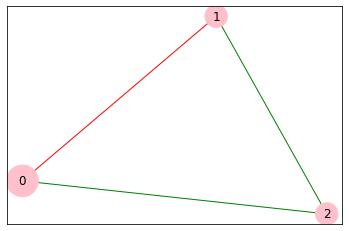

In [4]:
nx.draw_networkx(
    g,
    edge_color=[g.edges[e].get("color", "green") for e in g.edges],
    node_color="pink",
    node_size=[500 * g.nodes[n].get("peso", 1) for n in g.nodes],
)

`nx` usa "vistas" para exponer las propiedades de nodos, aristas y el grafo `g`. `g.nodes()` y `g.edges()` son las dos más importantes; otras como `g.degree()` (grados de cada nodo) y `g.adj` (**adj**acency, un diccionario de vecinos) son autoexplicativas:

In [5]:
g.nodes()

NodeView((0, 1, 2))

In [6]:
g.edges()

EdgeView([(0, 1), (0, 2), (1, 2)])

In [7]:
g.degree()

DegreeView({0: 2, 1: 2, 2: 2})

In [8]:
g.adj

AdjacencyView({0: {1: {'color': 'red'}, 2: {}}, 1: {0: {'color': 'red'}, 2: {}}, 2: {1: {}, 0: {}}})

In [9]:
list(g.neighbors(1))

[0, 2]

Si queremos crear un grafo dirigido, usaremos `nx.DiGraph` (**di**rected **graph**) en lugar de `nx.Graph`:

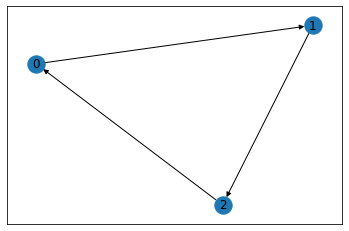

In [10]:
g = nx.DiGraph([(0, 1), (1, 2), (2, 0)])
nx.draw_networkx(g)

Ahora que las aristas están dirigidas, existen algunos métodos extra que diferencian las aristas (y el grado) de salida y entrada:

In [11]:
g.in_edges(1), g.out_edges(1)

(InEdgeDataView([(0, 1)]), OutEdgeDataView([(1, 2)]))

In [12]:
g.degree(), g.in_degree(), g.out_degree()

(DiDegreeView({0: 2, 1: 2, 2: 2}),
 InDegreeView({0: 1, 1: 1, 2: 1}),
 OutDegreeView({0: 1, 1: 1, 2: 1}))

In [13]:
g.pred, g.succ  # Nodos predecesores y sucesores

(AdjacencyView({0: {2: {}}, 1: {0: {}}, 2: {1: {}}}),
 AdjacencyView({0: {1: {}}, 1: {2: {}}, 2: {0: {}}}))

In [14]:
g.pred[1], g.succ[1]

(AtlasView({0: {}}), AtlasView({2: {}}))

También es posible crear grafos:
- con operaciones sobre otros (como `nx.cartesian_product(A, B)`),
- con constructores para grafos estándares (`nx.path_graph`) y famosos (`nx.erdos_renyi`)
- a partir de estructuras de datos externas
  - tablas ("DataFrames") de aristas (y otro de nodos),
  - matrices de adyacencia,
  - et cetera.

In [15]:
ciclo = nx.cycle_graph
grafos = [
    "nx.cartesian_product(ciclo(2), ciclo(3))",
    "nx.complete_graph(6)",
    "nx.barbell_graph(3, 3)",
    "ciclo(6)",
    "nx.path_graph(6)",
]

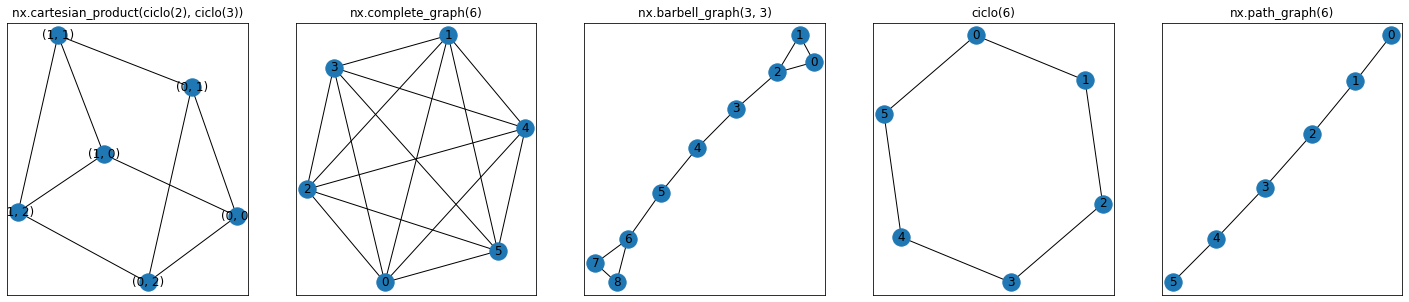

In [16]:
size = 5
n = len(grafos)
fig, axs = plt.subplots(1, n, figsize=(n * size, size))
for i in range(n):
    nombre = grafos[i]
    grafo = eval(nombre)
    ax = axs[i]
    nx.draw_networkx(grafo, ax=ax)
    ax.title.set_text(nombre)

## Visualización en `networkx`

NetworkX explícitamente recomienda no usar sus "precarias" herramientas de visualización, pero tienen la ventaja de "llevarse bien" con `matplotlib` ([sitio web](https://matplotlib.org/)), que es _la_ librería de facto para graficar datos en python.

`nx.draw_networkx` toma tres argumentos:
- el grafo a dibujar `g` (el único obligatorio),
- la posición de los nodos `pos` y
- _keyword arguments_ varios para controlar el estilo.

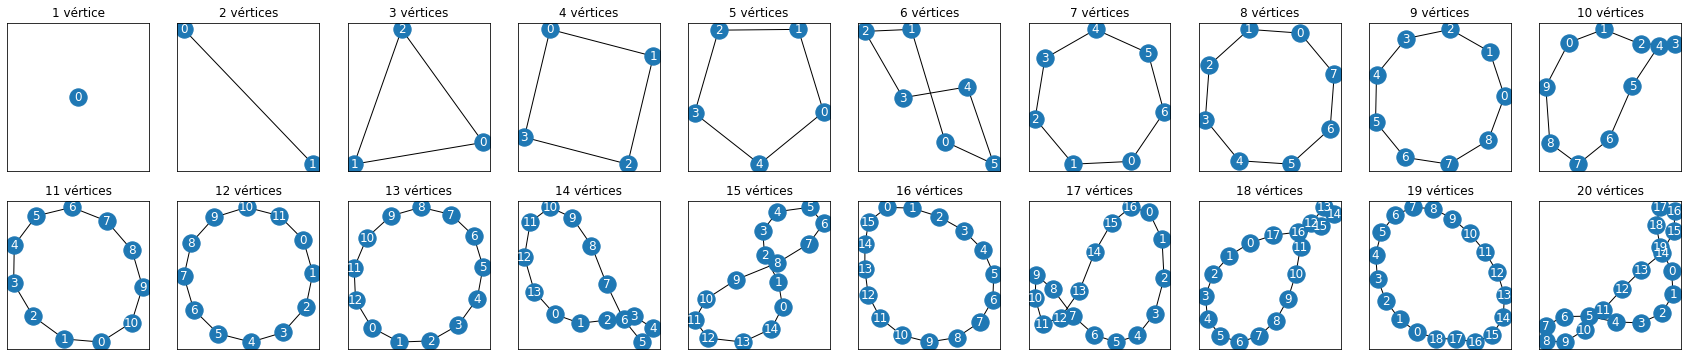

In [17]:
nrows, ncols = 2, 10
size = 3
kwargs={"with_labels": True, "font_color": "white"}
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * size, nrows * size))
for i in range(nrows):
    for j in range(ncols):
        ix = i * ncols + j + 1
        ax = axs[i, j]
        g = ciclo(ix)
        nx.draw_networkx(g, ax=ax, **kwargs)
        ax.title.set_text(f"{ix} vértice{'s' if ix > 1 else ''}")

¡Esos ciclos se ven bastante irregulares!

## Layouts

Típicamente, vamos a querer dibujar un ciclo como un polígono regular, con sus vértices inscriptos en una circunferencia.
Para ello, vamos a necesitar un _layout_ que controle estrictamente la posición de los nodos.

En el [Anexo 1](link), verán cómo generar un layout "a mano", ahora veamos cómo funcionan los ya incorporados a `nx`.

```
Signature: nx.draw_networkx(G, pos=None, arrows=True, with_labels=True, **kwds)
Docstring:
Draw the graph G using Matplotlib.

Draw the graph with Matplotlib with options for node positions,
labeling, titles, and many other drawing features.
See draw() for simple drawing without labels or axes.
```

```
Parameters
----------
G : graph
   A networkx graph

pos : dictionary, optional
   A dictionary with nodes as keys and positions as values.
   If not specified a spring layout positioning will be computed.
   See :py:mod:`networkx.drawing.layout` for functions that
   compute node positions.
```

In [18]:
nx.circular_layout(ciclo(4))

{0: array([9.99999986e-01, 2.18556937e-08]),
 1: array([-3.57647606e-08,  1.00000000e+00]),
 2: array([-9.9999997e-01, -6.5567081e-08]),
 3: array([ 1.98715071e-08, -9.99999956e-01])}

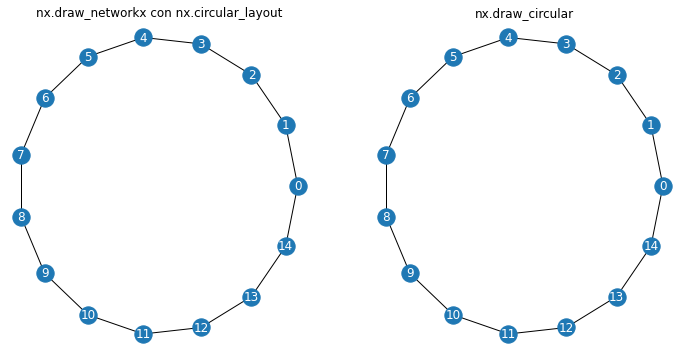

In [19]:
g = ciclo(15)
plt.figure(figsize=(12, 6))
plt.subplot(121)
nx.draw_networkx(g, pos=nx.circular_layout(g), **kwargs)
plt.title("nx.draw_networkx con nx.circular_layout")
plt.box(False)
plt.subplot(122)
nx.draw_circular(g, **kwargs)
plt.title("nx.draw_circular")
plt.show()

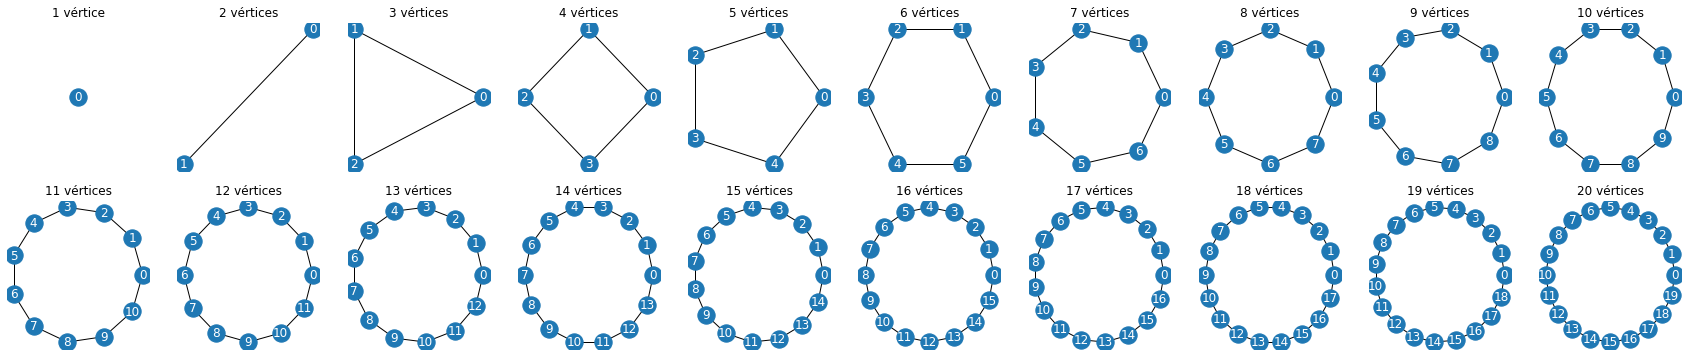

In [20]:
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * size, nrows * size))
for i in range(nrows):
    for j in range(ncols):
        ix = i * ncols + j + 1
        ax = axs[i, j]
        g = ciclo(ix)
        nx.draw_circular(g, ax=ax, **kwargs)
        ax.title.set_text(f"{ix} vértice{'s' if ix > 1 else ''}")

## Análisis

`nx` provee muchísimas funciones _sobre_ grafos, para estudiar sus propiedades. Consideremos por ejemplo el modelo de [Erdos-Renyi](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model) y su constructor en `nx`:

### nx.erdos_renyi_graph

`nx.erdos_renyi_graph(n, p, seed=None, directed=False)`

Returns a $G_{n,p}$ random graph, also known as an Erdős-Rényi graph or a binomial graph.

The $G_{n,p}$ model chooses each of the possible edges with probability $p$.

Ejercicio: ¿Qué distribución tiene el número de aristas $E$ en un grafo de Erdos-Renyi $G_{n,p}$?

In [21]:
ns = [3, 9, 27]
ps = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
grafos = {
    (n, p): nx.erdos_renyi_graph(n, p)
    for n in ns for p in ps
}

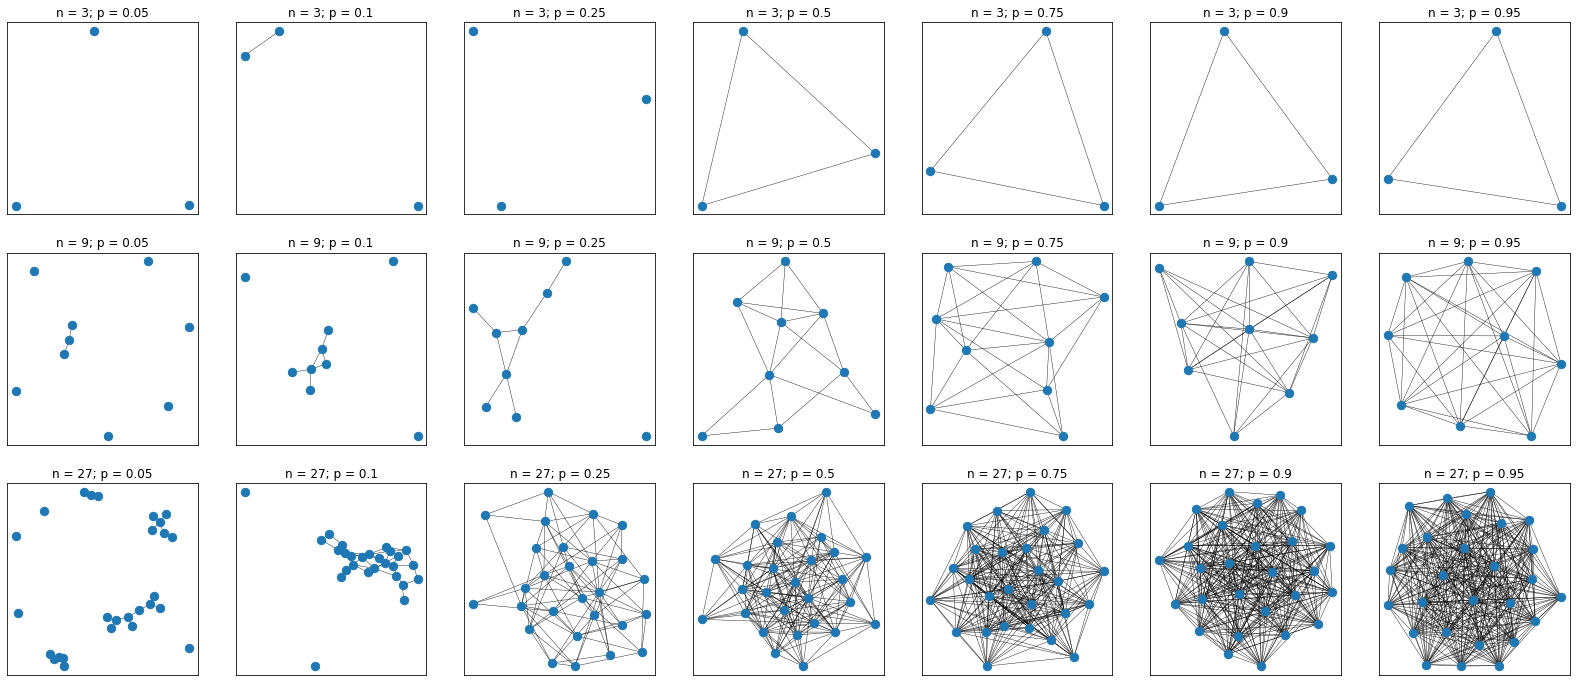

In [22]:
nrows, ncols = len(ns), len(ps)
size = 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * size, nrows * size))
for i, n in enumerate(ns):
    for j, p in enumerate(ps):
        ax = axs[i, j]
        g = grafos[(n, p)]
        nx.draw_networkx(g, ax=ax, node_size=70, width=0.4, with_labels=False)
        ax.title.set_text(f"n = {n}; p = {p}")

¿Cómo calcular la _distribución empírica_ del grado de los nodos de un grafo `g`?

In [23]:
pd.Series(dict(grafos[(27, 0.1)].degree())).value_counts()

2    9
3    7
4    4
5    3
0    2
1    2
dtype: int64

¿Funciona? Sí. Recién entonces la generalizo:

In [24]:
def distribucion_grado(g):
    grados = pd.Series(dict(g.degree()))
    return grados.value_counts()

Ejercicio: compare el resultado de `distribucion_grado(g)` con `pd.Series(nx.degree_histogram(g))`. ¿En qué difieren? ¿En qué coinciden?

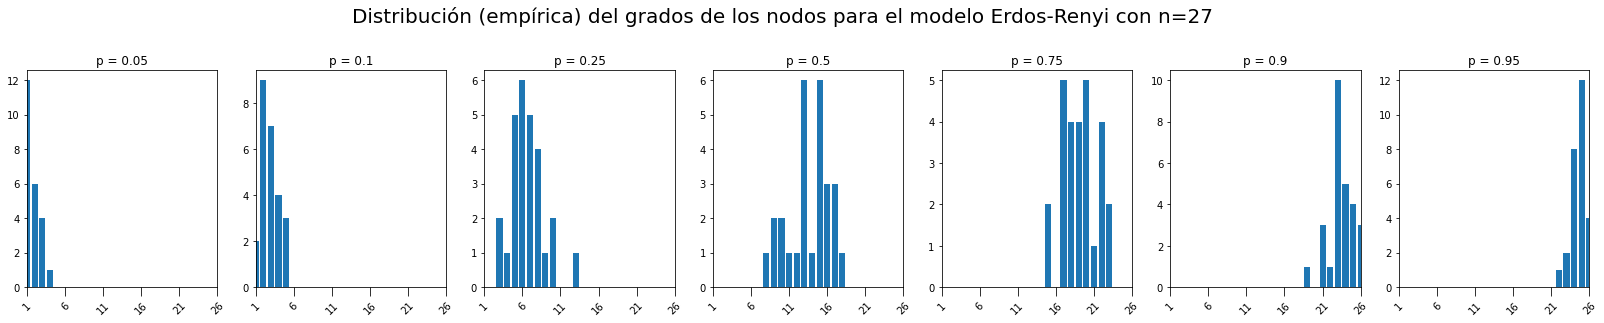

In [25]:
ncols = len(ps)
size = 4
fig, axs = plt.subplots(1, ncols, figsize=(ncols * size, size))
for i, p in enumerate(ps):
    ax = axs[i]
    g = grafos[(27, p)]
    dist = distribucion_grado(g)
    ax.bar(dist.index, dist.values)
    ax.set_xticks([1, 6, 11, 16, 21, 26])
    ax.tick_params('x', labelrotation=45, size=9)
    ax.set_xlim(1, 26)
    ax.title.set_text(f"p = {p}")
plt.suptitle(
    "Distribución (empírica) del grados de los nodos para el modelo Erdos-Renyi con n=27",
    size=20,
    y=1.1,
)
plt.show()

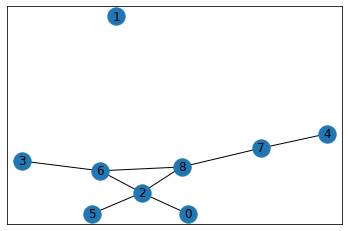

In [26]:
g = grafos[(9, 0.25)]
nx.draw_networkx(g)

In [27]:
list(nx.connected_components(g))

[{0, 2, 3, 4, 5, 6, 7, 8}, {1}]

In [28]:
nx.connected.is_connected(g)

False

In [29]:
nx.shortest_path == nx.shortest_paths.shortest_path

True

In [30]:
try:
    print(nx.shortest_path(g, 4, 8))
except Exception as e:
    print(repr(e))

[4, 7, 8]


Probar con otro grafo (conectado/no-conectado) y camino (que no ande/si ande)

#  ii. igraph

igraph (abreviado `ig`, /áigraf/)

Según el [sitio oficial](https://igraph.org/) (en - adivinen - inglés):
> igraph es una colección de herramientas para análisis de redes con énfasis en **eficiencia, portabilidad** y facilidad de uso. igraph es **código abierto** y gratuito. igraph puede ser programado en R, Python, Mathematica y C/C++

- Está escrita en C, así que es _mucho_ más rápida que NetworkX para unas cuantas tareas, y
- tiene su propio sistema de visualizaciones, basado en [Cairo](https://www.cairographics.org/).

En particular, vamos a usar los _bindings_ de [python](https://igraph.org/python), pero los interesados pueden explorarla en [R](https://igraph.org/r).
De mínima, como siempre, paséense por la [documentación](https://igraph.org/python/) de `python-igraph`, y lean detalladamente el [tutorial](https://igraph.org/python/doc/tutorial/tutorial.html),

Una cosa más: NetworkX e igraph están en "paridad funcional" para tareas estándar, pero puede que algunos generadores o algoritmos muy especializados/novedosos sólo se encuentren en una de ellas. Leyendo las novedades más recientes en en registro de cambios (`CHANGELOG`) de cada proyecto, se descubren métodos de lo más curiosos.

- [networkx](https://networkx.org/documentation/stable/news.html) (ver "Announcements" de cada versión, como la [última](https://networkx.org/documentation/stable/release/release_2.5.html), 2.5)
- [igraph (C)](https://github.com/igraph/igraph/blob/master/CHANGELOG.md) y [python-igraph](https://github.com/igraph/python-igraph/blob/master/CHANGELOG.md) (que suele estar algunas semanas atrás de la librería principal en C).

## Performance
Vaya aquí un test trivial de _algún_ método:

In [31]:
%%timeit -n100
g = nx.erdos_renyi_graph(100, 0.001)

751 µs ± 198 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
%%timeit -n100
h = ig.Graph.Erdos_Renyi(100, 0.001)

21.3 µs ± 6.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


¡`igraph` es $\frac{756 µs}{27.5 µs} > 20x$ más rápida que `networkx` (para esta tarea)!

## Creación de grafos

### Con métodos propios de la librería:

In [33]:
# Con un creador de la librería
g = ig.Graph.Ring(6)

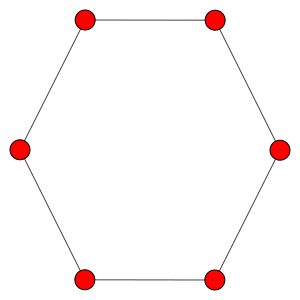

In [34]:
bbox = (300, 300)  # b(ounding) box - tamaño de la "cajita de pixeles" donde dibujar
ig.plot(g, bbox=bbox)

### Con una típica lista de aristas

In [35]:
g = ig.Graph([(0, 1), (1, 2), (2, 0)])

Los atributos especiales `g.vs` y `g.es` representan las listas de vértices y aristas

In [36]:
g.es, [e for e in g.es]

(<igraph.EdgeSeq at 0x7fb7c0e343b0>,
 [igraph.Edge(<igraph.Graph object at 0x7fb7cb455c70>, 0, {}),
  igraph.Edge(<igraph.Graph object at 0x7fb7cb455c70>, 1, {}),
  igraph.Edge(<igraph.Graph object at 0x7fb7cb455c70>, 2, {})])

In [37]:
g.vs, [v for v in g.vs]

(<igraph.VertexSeq at 0x7fb7c0e34270>,
 [igraph.Vertex(<igraph.Graph object at 0x7fb7cb455c70>, 0, {}),
  igraph.Vertex(<igraph.Graph object at 0x7fb7cb455c70>, 1, {}),
  igraph.Vertex(<igraph.Graph object at 0x7fb7cb455c70>, 2, {})])

Vértices y aristas aceptan atributos al igual que en `nx`. Algunos atributos (como `color`) determinan el estilo de la visualización por defecto, que se puede modificar con _keyword arguments_ a `ig.plot`.

In [38]:
g.vs[0]["peso"] = 2
edge_01 = g.get_edgelist().index((0, 1))
g.es[edge_01]["color"] = "red"

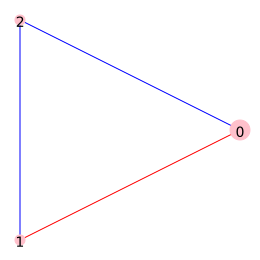

In [39]:
visual_style = {
    "vertex_size": [10 * (peso or 1) for peso in g.vs["peso"]],
    "edge_color": [(color or "blue") for color in g.es["color"]],
    "vertex_color": "pink",
    "vertex_frame_color": "pink",  # Para "desaparecer" el contorno negro
    "vertex_label": [i for i, _ in enumerate(g.vs)],
}
ig.plot(g, bbox=(260, 260), **visual_style)

### Resumen de características
Los comandos internos `summary(g)` en R y en `print(g)` en Python producen un resumen útil de los atributos principales de un grafo. En [el tutorial](https://igraph.org/python/doc/tutorial/tutorial.html#creating-a-graph-from-scratch) se menciona lo básico al respecto, y en [la documentación](https://igraph.org/python/doc/api/igraph.summary%200.GraphSummary.html) está el detalle.

In [40]:
print(g)

IGRAPH U--- 3 3 --
+ attr: peso (v), color (e)
+ edges:
0--1 1--2 0--2


In [41]:
print(ig.Graph.Erdos_Renyi(100, 0.001, directed=True))

IGRAPH D--- 100 11 --
+ edges:
83->26 20->39 71->40 91->45 17->49 95->50 40->57 34->66 79->70 45->74 39->97


### Construyéndolo a mano

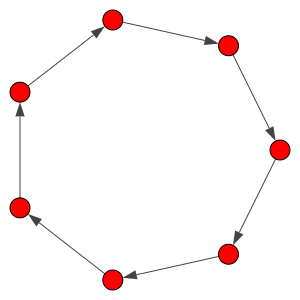

In [42]:
n = 7
g = ig.Graph(directed=True)
g.add_vertices(range(n))
g.add_edges([(i, (i + 1) % n) for i in range(n)])
ig.plot(g, bbox=bbox)

Ejercicio: ¿Hay algún comando superfluo en la celda anterior?

### Usando generadores

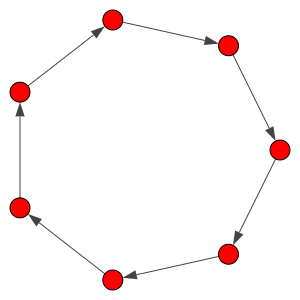

In [43]:
g = ig.Graph.Ring(n, directed=True)
ig.plot(g, bbox=bbox)

### Importándolo de networkx

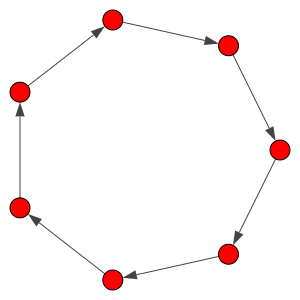

In [44]:
g = ig.Graph.from_networkx(ciclo(n, create_using=nx.DiGraph))
ig.plot(g, bbox=bbox) 

## iii. interoperabilidad

¿Cómo "mover" un grafo a otro programa?

- estructuras de datos estándar: GraphML, GML, et al

- representaciones básicas: lista de aristas, matriz de adyacencia

- para análisis de datos: tablas de aristas y (opcionalmente) nodos

- para visualizar (más adelante):
  - listas de nodos (nodes) y aristas (links) compatibles con [`d3`](https://d3js.org/)
  - formato `dot` para [GraphViz](http://www.graphviz.org/)

### Formatos estándar - GraphML

Ambos módulos ([networkx](https://networkx.org/documentation/stable/reference/readwrite/index.html) e [igraph](https://igraph.org/python/doc/tutorial/tutorial.html#igraph-and-the-outside-world) proveen bien documentados métodos para leer y escribir a formatos estándares variopintos. TL; DR:

En `igraph`,
- `h.write_FORMAT(path)` escribe el grafo `h` en formato `FORMAT` al archivo `path`.
- `igraph.Graph.Read_FORMAT(path)` o simplemente `igraph.read(path)` carga el grafo definido en `path`, según `FORMAT` (primer sintaxis) o implícitamente (segunda sintaxis)

En networkx,
- `nx.read_FORMAT(path)` carga el grafo definido en path, según `FORMAT`
- `nx.write_FORMAT(g, path)` escribe el grafo `g` en formato `FORMAT` al archivo `path`

Googleando por ahí, _estimo_ que [GraphML](http://graphml.graphdrawing.org/) ([wikipedia](https://en.wikipedia.org/wiki/GraphML)) es el _más estándar de los estándares_.

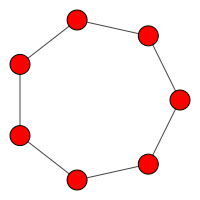

In [45]:
nx.write_graphml(ciclo(n), "nx-anillo.graphml")
ig.plot(ig.read("nx-anillo.graphml"), bbox=(200, 200))

Nótese que si creamos un ciclo dirigido, se mantiene la propiedad al leerlo con otra librería.

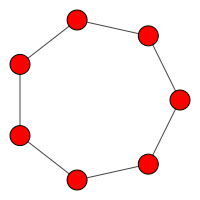

In [46]:
ig.Graph.Ring(n).write_graphml("ig-anillo.graphml")
ig.plot(ig.Graph.Read_GraphML("ig-anillo.graphml"), bbox=(200, 200))

### Representaciones básicas

#### Matriz de adyacencia

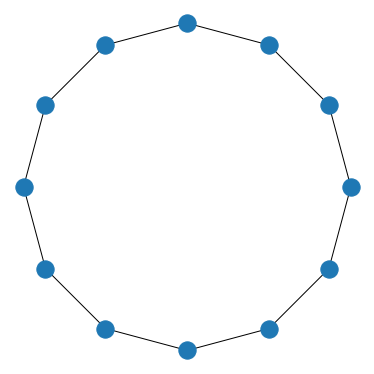

In [47]:
mpl.rcParams["figure.figsize"] = 5, 5
adj = nx.to_numpy_matrix(ciclo(12))
nx.draw_circular(nx.from_numpy_matrix(adj))

### Representaciones básicas

#### Matriz de adyacencia

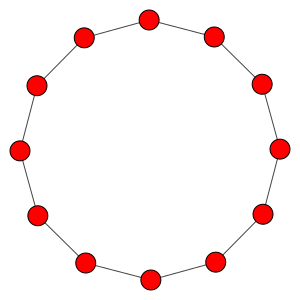

In [48]:
adj = ig.Graph.Ring(12).get_adjacency()  # adj es de tipo ig.Matrix, adj.data tiene la matriz "pelada"
ig.plot(
    # ig.ADJ_UNDIRECTED es una constante del módulo que indica el "modo de creación" del grafo. 
    ig.Graph.Adjacency(adj.data, mode=ig.ADJ_UNDIRECTED),
    bbox=bbox,
)

### Representaciones básicas

#### Lista de aristas

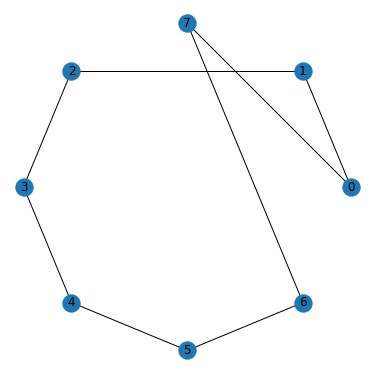

In [49]:
el = nx.to_edgelist(ciclo(8))
nx.draw_circular(nx.from_edgelist(el), with_labels=True)

### Representaciones básicas

#### Lista de aristas

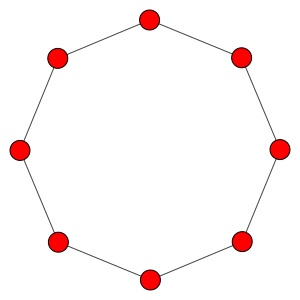

In [50]:
el = ig.Graph.Ring(8).get_edgelist()
ig.plot(ig.Graph(el), bbox=bbox)

### Tablas de aristas y nodos

Lo único difícil sobre como crear un grafo a partir de dos tablas con información de nodos y aristas, es construirlas; importarlas a `nx` o `ig` es trivial.

Vamos a construir el grafo de tráfico aéreo nacional, a partir de un dataset de aeropuertos - los nodos - y rutas aéreas - las aristas. Para ahondar en los detalles de la construcción de los prolijos CSVs provistos - y de paso repasar manejo básico de `pandas` -, en el [Anexo 1](link) está el detalle.

In [51]:
nodes = pd.read_csv("data/nodos-aeropuertos.csv")
edges = pd.read_csv("data/aristas-rutas-aereas.csv") 

In [52]:
nodes.head(3)

,oaci,denominacion,latitud,longitud,elev,condicion,trafico
0,SAWD,Puerto Deseado,-47.735110,-65.904100,82.0,Publico,Nacional
1,SABE,Buenos Aires / Aeroparque J. Newbery,-34.558889,-58.416389,5.6,Publico,Internacional
2,SAVA,Piedra Del Águila,-40.192320,-70.010750,649.0,Privado,Nacional


In [53]:
edges.head(3)

,origen,destino,vuelos
0,SAAC,SADF,2
1,SAAC,SADM,1
2,SAAP,SAAC,1


In [54]:
g = nx.from_pandas_edgelist(
    edges,  # dataframe con aristas
    source="origen",
    target="destino",
    edge_attr=True,  # Transforma en atributos todo el resto de las columnas
    create_using=nx.DiGraph  # Este será un grafo dirigido
)

¿Estarán incluidos todos los nodos? 

In [55]:
len(g.nodes), len(nodes)

(93, 124)

¡Evidentemente no! Completemos el gráfico, agregando los nodos que no existen, y seteando atributos para todos. Esto se puede hacer "de una sola pasada", usando `g.add_nodes_from`:

In [56]:
node_attributes = nodes.set_index("oaci").to_dict("index")

In [57]:
node_attributes["SAEZ"]

{'denominacion': 'Ezeiza / Ministro Pistarini',
 'latitud': -34.82222222,
 'longitud': -58.53583333,
 'elev': 20.5,
 'condicion': 'Publico',
 'trafico': 'Internacional'}

`g.add_nodes_from` espera _tuplas_ de la forma (nodo, atributos), así que llamarla con la vista `dict.items()` y no el `dict` "crudo"

In [58]:
g.add_nodes_from(node_attributes.items())

¡Intentemos graficarlo!

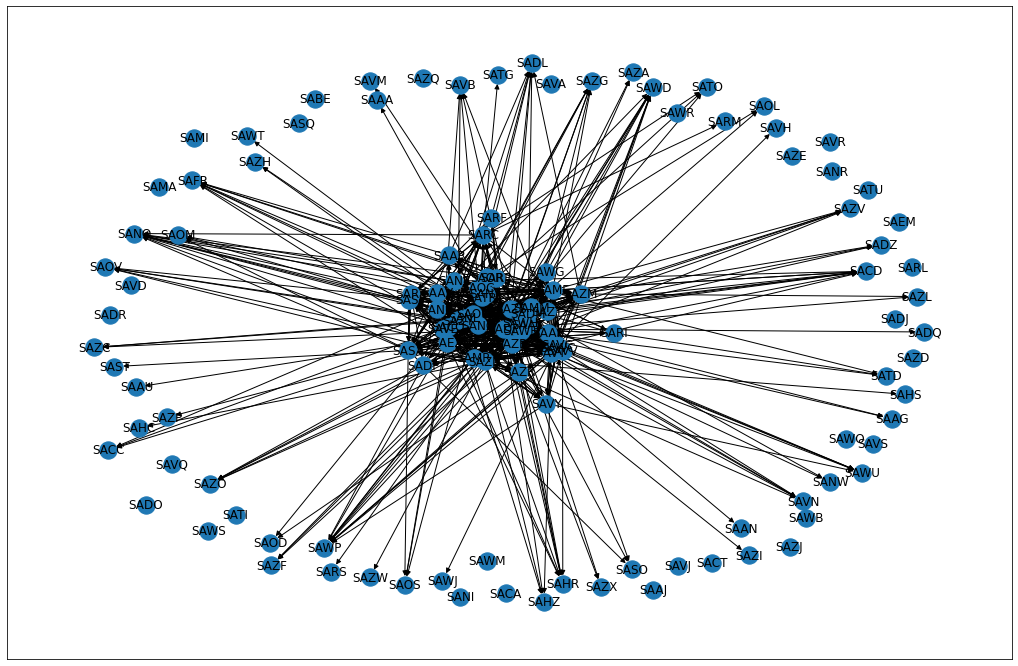

In [59]:
fig, ax = plt.subplots(figsize=(18, 12))
nx.draw_networkx(g)

Está muy atestada... Tal vez limitando la cantidad de aristas en función de su peso, y excluyendo a los nodos de grado cero, mejora:

In [60]:
edges.vuelos.describe()

count    765.000000
mean      15.998693
std       52.673312
min        1.000000
25%        1.000000
50%        2.000000
75%       10.000000
max      872.000000
Name: vuelos, dtype: float64

Conservemos las rutas en el cuartil superior de vuelos. Esta vez, agregamos los atributos de nodos usando `nx.set_node_attributes`, que sólo agregará atributos para los nodos preexistentes:

In [61]:
g = nx.from_pandas_edgelist(edges[edges.vuelos >= 10], "origen", "destino", "vuelos", nx.DiGraph)
nx.set_node_attributes(g, node_attributes)

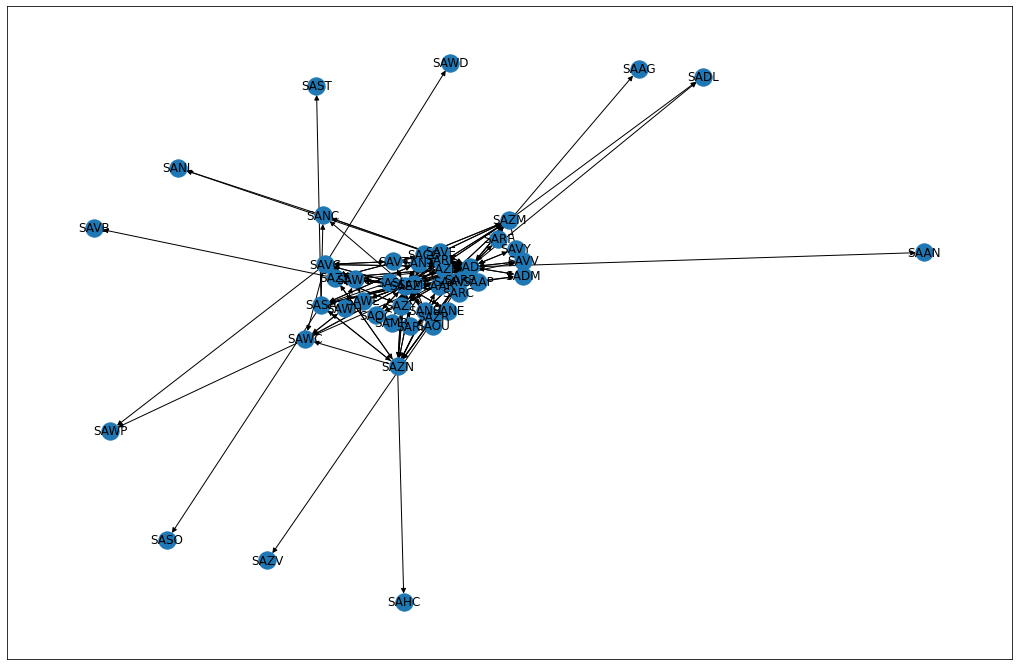

In [62]:
fig, ax = plt.subplots(figsize=(18, 12))
nx.draw_networkx(g)

Sigue sin ser una visualización muy satisfactoria. ¿Por qué no usar latitud y longitud como posición en el `layout`?

In [63]:
pos = {k: (v["longitud"], v["latitud"]) for k, v in node_attributes.items()}

 De paso, estilizamos según algunos atributos

In [64]:
visual = {}
visual["font_size"] = 10
visual["alpha"] = 0.5
visual["edge_color"] ="gray"
grados = nx.degree(g)
visual["node_size"] = [5 * grados[nodo] for nodo in g]

visual["node_color"] = list(nx.get_node_attributes(g, "elev").values())
visual["cmap"] = plt.cm.autumn  # c(olor) map para los nodos
visual["labels"] = {
    nodo: denom.replace(" / ", "\n") if grados[nodo] >= 5 else ''
    for nodo, denom in g.nodes.data("denominacion")
}
vuelos = nx.get_edge_attributes(g, "vuelos")
visual["width"] = [(0.025 * vuelos[arista])**0.5 for arista in g.edges()]

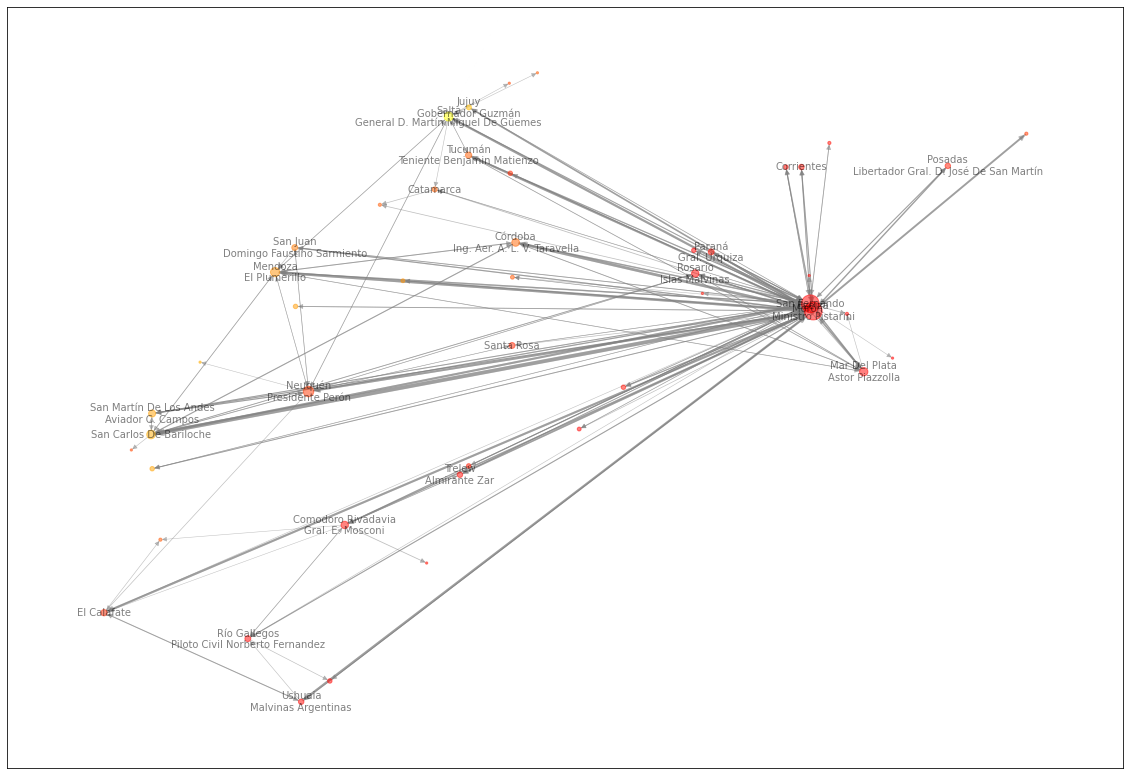

In [65]:
# pos = {id_nodo: (lon, lat) p/c id_nodo en nodos}
fig, ax = plt.subplots(figsize=(20, 14))
nx.draw_networkx(g, pos=pos, ax=ax, **visual)

Ejercicio: Cambie `node_size` para que la escala refleje la suma de los vuelos de todas las aristas incidentes. ¿Cómo cambia el gráfico? ¿Qué le dice ello?

**Desafío**: ¿Puede recrear este mapa - o sus elementos principales - con `igraph`?

OK, la forma es mas "argentinosa", pero está lejos de ser un mapa. ¡Tratemos de hacerlo un mapa!

# iv. grafos geográficos

## Geopandas y CartoPy
Hay algunas herramientas bastante "amistosas" para dibujar elementos geográficos en Python, en particular,
- `cartopy` extiende `matplotlib` con un tipo de eje (`ax`) especial, `GeoAxes`, que simplifica enormemente el ploteo, y
- `geopandas`, que extiende `pandas` con un `GeoDataFrame` para albergar formas ("shapes") como puntos, líneas y polígonos.

**Sobre la instalación**: Las dependencias de ambas librerías (como el plotting de `igraph` con `pycairo` son _complejas_ de instalar "a mano", y aún en Google Colab pueden dar problemas. La recomendación oficial de "la cátedra", es hacerlo con `conda` según el [ambiente de referencia](https://github.com/fcen-amateur/aa-en-grafos/blob/main/environment.yml) provisto.

Como siempre, la documentación es su amiga: [GeoPandas](https://geopandas.org/index.html), [CartoPy](https://scitools.org.uk/cartopy/docs/latest/)

In [66]:
import geopandas as gpd
import cartopy.feature as cfeature
import cartopy.crs as ccrs

In [67]:
ARGENTINA = (-76, -50, -55, -22)  # "Cajita" que contiene el territorio continental nacional
provincias = gpd.read_file("data/Provincia/ign_provincia.shp")

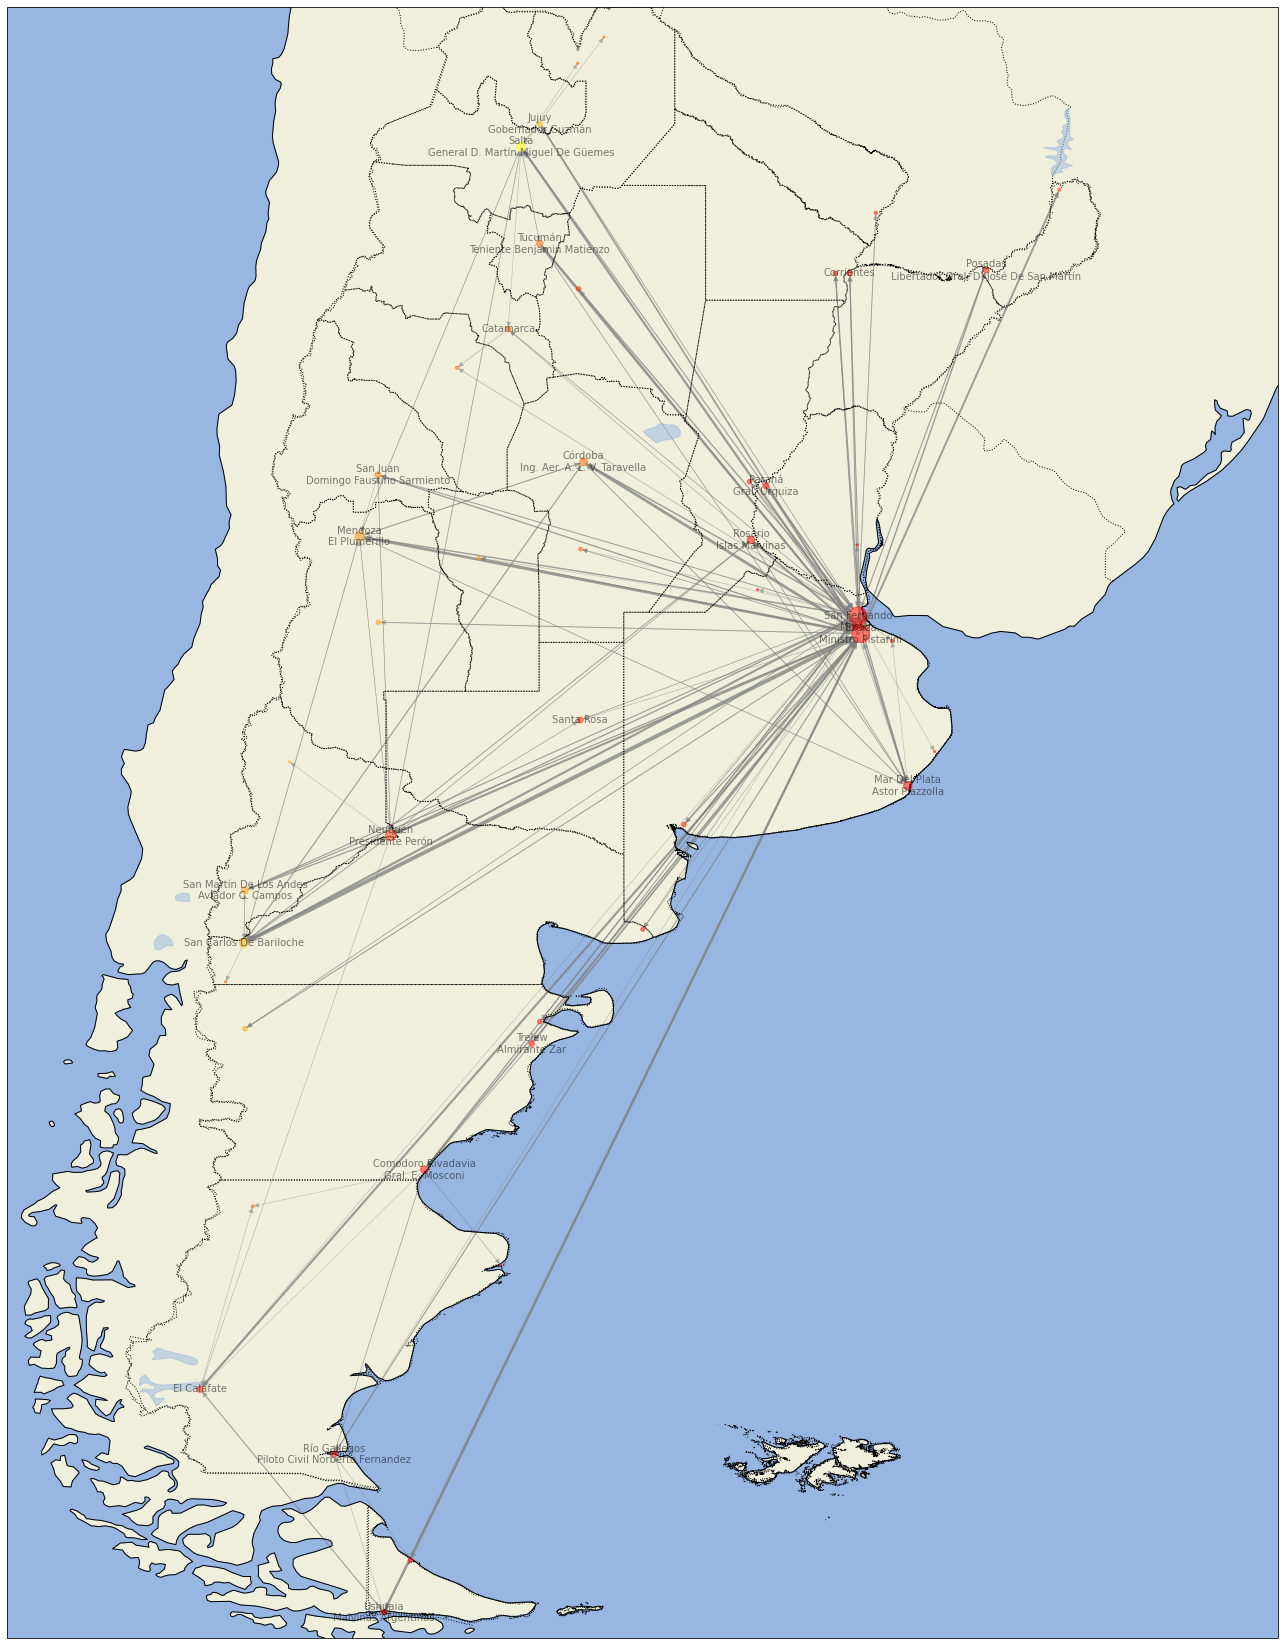

In [68]:
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(
    1, 1, figsize=(24, 30),
    subplot_kw=dict(projection=crs)
)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_geometries(provincias['geometry'], facecolor="none", linestyle="dotted", crs=crs)
ax.set_extent(ARGENTINA)
# ax.set_global() da la extensión mundial
nx.draw_networkx(g, pos=pos, ax=ax, **visual)
plt.show()

### Listado de nodos y aristas

[D3](https://d3js.org/) (Data-Driven Documents) es una librería de JavaScript para realizar visualizaciones de lo más bellas. Está escrita en JavaScript, así que es HTML, sumamente flexible y produce documentos realmente bellísimos.

De les mismes creadores, [Observable](https://observablehq.com/) ofrece notebooks con JavaScript y D3 sencillos de usar.

`d3` espera un objeto JSON (un diccionario, a fines prácticos) con dos claves, `nodes` y `links`, donde el valor de cada una es una lista con la información de vértices y aristas, respectivamente.

- `nx.node_link_data` exporta el grafo en un [formato JSON](https://networkx.org/documentation/stable/reference/readwrite/json_graph.html) compatible con D3, y
- y `nx.node_link_graph` crea un grafo de `nx` a partir de dicho formato.

In [69]:
import json
h = ciclo(3)
archivo = "data/ciclo.json"
data = nx.node_link_data(h)
print(data)

{'directed': False, 'multigraph': False, 'graph': {}, 'nodes': [{'id': 0}, {'id': 1}, {'id': 2}], 'links': [{'source': 0, 'target': 1}, {'source': 0, 'target': 2}, {'source': 1, 'target': 2}]}


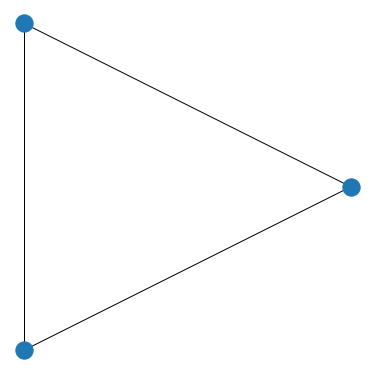

In [70]:
with open(archivo, "w") as f:  # Abro `archivo` en modo escritura - w(rite)
    json.dump(data, f)
with open(archivo, "r") as f:  # Abro `archivo en modo lectura - r(ead)
    data = json.load(f)
    nx.draw_circular(nx.node_link_graph(data))

In [71]:
json.dump(nx.node_link_data(g), open("data/grafo-aereo.json", "w"))

Ejercicio : Pasee por https://observablehq.com, o vaya directo a [esta](https://observablehq.com/@d3/force-directed-graph) visualización del elenco de *Les Miserables*, adjunte al archivo `grafo-aereo.json`, y cambie el código de la visualización para que lo utilice. ¿Puede reproducir los atributos visuales que usamos antes?

# Fin

Gracias :)

[`aag`](https://github.com/fcen-amateur/aa-en-grafos), 2021, ningún derecho reservado.